In [10]:
# Imports nécessaires

%matplotlib inline

# Suppression de l'affichage des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')
import string

from sklearn import model_selection
from sklearn import set_config
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import nltk
from sklearn.svm import SVC

import seaborn as sns

# Pour éviter l'affichage tronqué des descriptions
pd.set_option('display.max_colwidth', -1) 
# Pour la visualisation des pipelines sklearn
set_config(display='diagram')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/maxime/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/maxime/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Projet TAL : TF-IDF, stemming, lemmatisation et différents modèles

Dans ce notebook, nous allons étudier les performances de différents modèles de classification sur le corpus de description de films. Nous allons également étudier l'impact de la lemmatisation et du stemming sur les performances des modèles.

## 1. Importation des données

In [11]:
# Recuperation des données
cine_df = pd.read_csv('data/allocine_genres_train.csv', index_col=0)

# Suppression de toutes les colonnes sauf 'synopsis', 'titre' et 'genre'
cine_df = cine_df.drop(columns=['acteur_1', 'acteur_2', 'acteur_3', 'allocine_id','annee_prod', 'annee_sortie', 'box_office_fr'])
cine_df = cine_df.drop(columns=['couleur', 'duree', 'langues','nationalite', 'nb_critiques_presse',  'nb_critiques_spectateurs'])
cine_df = cine_df.drop(columns=['nb_notes_spectateurs', 'note_presse',  'note_spectateurs', 'realisateurs', 'type_film'])

Avant de convertir les labels en entiers, nous allons d'abord vériifer que les labels sont bien équilibrés.

In [12]:
cine_df['genre'].value_counts()

drame              501
comédie            483
romance            443
policier           331
horreur            299
science fiction    298
biopic             191
documentaire       167
historique         162
Name: genre, dtype: int64

On note que les labels ne sont pas équilibrés. Nous allons donc utiliser la métrique F1 pour évaluer les performances des modèles. Pour améliorer les performances, nous aurions pus réaliser de l'augmentation de données, mais nous avons préféré ne pas le faire pour ne pas risqué de manquer de temps.

In [13]:
# Fusionne les colonnes 'titre' et 'synopsis' en une seule colonne 'texte'
cine_df['texte'] = cine_df['titre'] + ' ' + cine_df['synopsis']
cine_df = cine_df.drop(columns=['titre', 'synopsis'])

# Convertit les genres en labels numériques
cine_df['label'] = cine_df['genre'].astype('category')
cine_df['label'] = cine_df['label'].cat.codes
cine_df = cine_df.drop(columns=['genre'])

In [21]:
cine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875 entries, 4772 to 3090
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texte   2875 non-null   object
 1   label   2875 non-null   int8  
dtypes: int8(1), object(1)
memory usage: 47.7+ KB


On as maintenant un dataset propre et ne contenant que nos input et nos output. Cela simplifiera la création de la pipeline.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(cine_df['texte'], cine_df['label'], test_size=0.2, random_state=42, shuffle=True)

X_test et y_test serons utilisés pour la validation.

## 2. Preprocessing

On charge les modèles nescessaires.

In [15]:
stopwords_fr = stopwords.words('french') + list(string.punctuation)

# Ajouter les s', l', d'... aux stopwords
stopwords_fr.extend(["d'", "l'", "s'", "n'", "c'", "qu'", "j'", "m'", "t'", "’"])

nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

On définie les fonctions de preprocessing.

In [16]:
def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word not in stopwords_fr])

def normalize(text):
    text = text.replace('œ', 'oe').replace('æ', 'ae').replace('«', '').replace('»', '').replace('-',' ').replace('   ',' ')
    text = text.replace('é','e').replace('è','e').replace('ê','e').replace('à','a').replace('â','a').replace('ô','o').replace('î','i')
    text = text.replace('ï','i').replace('û','u').replace('ù','u').replace('ç','c').replace('ë','e').replace('ü','u').replace('ÿ','y')
    text = text.replace('ñ','n').replace('É','E').replace('È','E').replace('Ê','E').replace('À','A').replace('Â','A').replace('Ô','O')
    text = text.replace('Î','I').replace('Ï','I').replace('Û','U').replace('Ù','U').replace('Ç','C').replace('Ë','E').replace('Ü','U')
    text = text.replace('Ÿ','Y').replace('Ñ','N').replace('(','').replace(')','').replace('…', '...')
    return text

def stemming_text(text):
    stemmer = nltk.stem.SnowballStemmer('french')
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

def preprocess_text_stemming(text):
    text = remove_stopwords(text)
    text = normalize(text)
    text = stemming_text(text)
    return text.lower()

def preprocess_text_lemmatize(text):
    text = remove_stopwords(text)
    text = normalize(text)
    text = lemmatize_text(text)
    return text.lower()

def preprocess_texts_stemming(texts):
    return [preprocess_text_stemming(text) for text in texts]

def preprocess_texts_lemmatize(texts):
    return [preprocess_text_lemmatize(text) for text in texts]

On teste le preprocessing avec stemming et lemmatisation.

In [17]:
text = "En visite à Istanbul , le célèbre détective belge Hercule Poirot embarque dans l’ Orient - Express , luxueux train reliant la capitale turque à Calais . Il fait connaissance avec les autres passagers : la volubile Américaine Mme Hubbard , la princesse russe Dragomiroff et sa servante Hildegarde , ou le séduisant comte hongrois Andrenyi et sa femme . Un matin , alors que le train est immobilisé sous la neige , les passagers découvrent avec effroi que M. Ratchett , antipathique homme d’ affaires américain , a été froidement assassiné dans sa cabine durant la nuit . Pour Hercule Poirot , cela ne fait aucun doute : le meurtrier se trouve parmi les treize personnes à bord …"
print(preprocess_text_stemming(text))
print(preprocess_text_lemmatize(text))

en visit istanbul celebr detect belg hercul poirot embarqu orient express luxueux train reli capital turqu cal il fait connaiss autr passager volubil americain mme hubbard princess russ dragomiroff serv hildegard seduis comt hongrois andreni femm un matin alor train immobilis sous neig passager decouvrent effroi m. ratchet antipath homm affair americain a froid assassin cabin dur nuit pour hercul poirot cel fait aucun dout meurtri trouv parm treiz person bord ...
en visite istanbul celebre detectiv belge hercule poirot embarqu orient express luxueux train relier capital turc calais il faire connaissance autre passager volubile americaine mme hubbard princesse russe dragomiroff servant hildegarde seduiser comt hongrois andrenyi femme un matin alors train immobilis sou neige passager decouvrent effroi m. ratchett antipathique homme affaire americain avoir froidement assassine cabin durer nuit pour hercule poirot celer faire aucun doute meurtrier trouver parmi treize personne bord ...


## 3. Pipeline TF-IDF

On créer le vectorizer TF-IDF. La fréquence minimale est de 5 pour éviter d'avoir des mots trop rares. Cette fréquence est un hyperparamètre que l'on as tuned au préalable.

In [18]:
vectorizer = TfidfVectorizer(tokenizer = lambda x : str.split(x, ' '), min_df=0.005)

On créer les deux pipelines (stemming et lemmatisation) avec TF-IDF.

In [19]:
prepro_stemming = FunctionTransformer(func=preprocess_texts_stemming, validate=False)
prepro_lemmatize = FunctionTransformer(func=preprocess_texts_lemmatize, validate=False)

pipeline_stem = Pipeline([('preprocess_pipeline', prepro_stemming), ('vectorizer_pipeline', vectorizer)])
pipeline_lemm = Pipeline([('preprocess_pipeline', prepro_lemmatize), ('vectorizer_pipeline', vectorizer)])

## 4. Comparaison des modèles et des prétraitements

In [ ]:
# Modèles à tester
models = [
    ('Dummy', DummyClassifier(strategy='most_frequent')),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('SVM', SVC()),
    ('Multinomial Naive Bayes', MultinomialNB())
]

# Pipelines à tester
pipelines = [("",pipeline_stem)]

# Evaluation des modèles et des pipelines
scores = []
names = []
scoring = 'f1_macro'
# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
# Itération sur les modèles et les pipelines
for name, model in models:
    for pipe_name, pipeline in pipelines:
        # Ajout du nom du modèle et du pipeline à la liste name
        names.append(name + ' + ' + pipe_name)
        # Création de la pipeline pour le modèle
        model_pipeline = make_pipeline(pipeline, model)
        # Entrainement du modèle
        model_pipeline.fit(X_train, y_train)
        # Evaluation du modèle
        cv_results = model_selection.cross_val_score(model_pipeline, X_test, y_test, cv=kfold, scoring=scoring)
        # Ajout du score moyen à la liste scores
        scores.append(cv_results.mean())

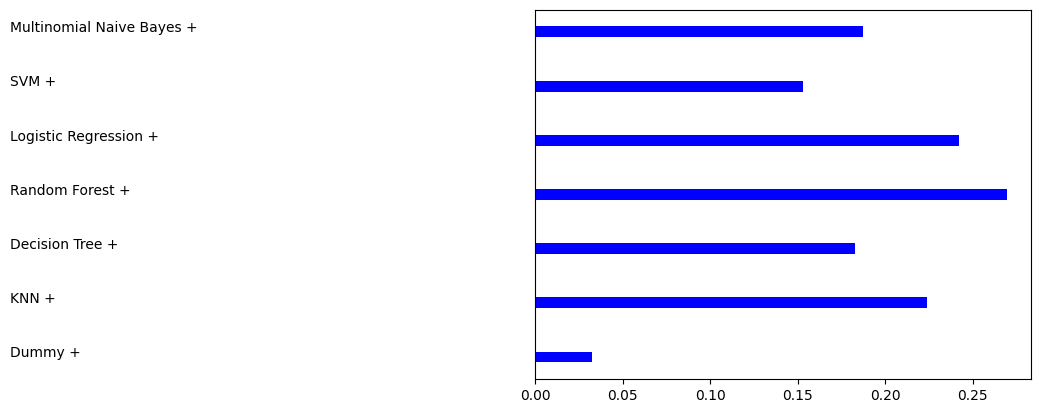

In [60]:
# Représentation graphique des résultats
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()

On remarque tout d'abord que le stemming est plus efficace que la lemmatisation. De plus le stemming est plus rapide que la lemmatisation. Nous allons donc utiliser le stemming pour la suite.

Quand au modèle, le modèle le plus efficace est le modèle de forêt aléatoire. On s'attendait à ce que le meilleurs modèle soit la Logistic Regression.

## 5. Evaluation du meilleur modèle

In [45]:
model_pipeline = make_pipeline(pipeline_stem, RandomForestClassifier())
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocess_pipeline',
                                  FunctionTransformer(func=<function preprocess_texts_stemming at 0x7faea84b4f70>)),
                                 ('vectorizer_pipeline',
                                  TfidfVectorizer(min_df=0.005,
                                                  tokenizer=<function <lambda> at 0x7fae23d4a9e0>))])),
                ('randomforestclassifier', RandomForestClassifier())])

Nous allons maintenant évaluer le meilleur modèle sur le jeu de test. Pour cela, nous allons utiliser la métrique F1, et la matrice de confusion.

              precision    recall  f1-score   support

           0       0.21      0.10      0.14        30
           1       0.38      0.57      0.46        98
           2       0.73      0.34      0.47        32
           3       0.34      0.47      0.39        90
           4       0.50      0.11      0.18        37
           5       0.44      0.23      0.30        52
           6       0.59      0.55      0.57        84
           7       0.45      0.47      0.46        89
           8       0.56      0.63      0.60        63

    accuracy                           0.45       575
   macro avg       0.47      0.39      0.40       575
weighted avg       0.46      0.45      0.43       575



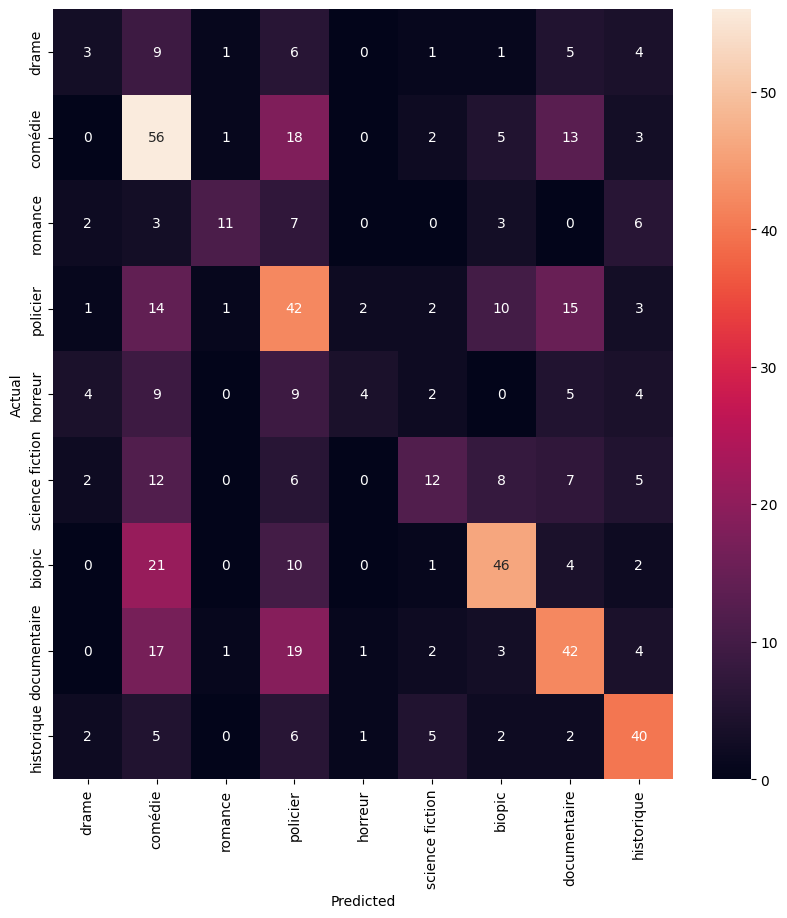

In [46]:
# Evaluation du modèle
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Matrice de confusion

categories = ['drame', 'comédie', 'romance', 'policier', 'horreur', 'science fiction', 'biopic', 'documentaire', 'historique']

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()